# Image super-resolution with a U-Net-like architecture

**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Getting started
First, we check the version of Tensorflow and set the seeds for reproducibility.

In [ ]:
import tensorflow as tf

import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

seed = 42
img_size = (256,256) #gt_image size, and network output size
down_factor = 4
preprocess_data = True # turn False if you have ready your data
data_augmentation = True
BATCH_SIZE = 1

downscale_img_size = (img_size[0]//down_factor, img_size[1]//down_factor)
up_factor = down_factor

def set_seed(seedValue=42):
  """Sets the seed on multiple python modules to obtain results as
  reproducible as possible.
  Args:
  seedValue (int, optional): seed value.
  """
  np.random.seed(seed=seedValue)
  tf.random.set_seed(seedValue)
  os.environ["PYTHONHASHSEED"]=str(seedValue)
  random.seed(seedValue)
set_seed(seed)
print("Tensorflow version: ", tf.__version__ )

Tensorflow version:  2.5.0


Download the data

In [ ]:
import os
if not os.path.exists('./oxford-iiit-pet.tgz'):
    if not os.path.exists('./images.tar.gz') or not os.path.exists('./annotations.tar.gz'):
        !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
        !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
        !tar -xf images.tar.gz
        !tar -xf annotations.tar.gz   

In [ ]:
if not os.path.exists('./images.tar.gz') or not os.path.exists('./annotations.tar.gz'):
    if not os.path.exists('./oxford-iiit-pet.tgz'):
        !curl -O https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz
        !tar -xf oxford-iiit-pet.tgz
        !mv ./oxford-iiit-pet/annotations ./
        !mv ./oxford-iiit-pet/images ./
        !rmdir ./oxford-iiit-pet

## Data modifications

### Splits

Prepare paths of input images and target segmentation masks

In [ ]:
import pandas as pd

filename = "annotations/trainval.txt"
train = pd.read_csv(filename, sep=' ',  names = ['names', 'class-id', 'specie', 'breed'], encoding="utf-8", skiprows=0)

filename = "annotations/test.txt"
test = pd.read_csv(filename, sep=' ',  names = ['names', 'class-id', 'specie', 'breed'], encoding="utf-8", skiprows=0)

#print(test)
#print(train)

In [ ]:
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

input_dir = "images/"
target_dir = "annotations/trimaps/"

train_img_paths = []
test_img_paths = []

for i, fname in enumerate(train['names']):
    x = os.path.join(input_dir, fname + ".jpg")
    y = os.path.join(target_dir, fname + ".png")
    #c = train['class-id'][i]
    train_img_paths.append( (x,y) )
for i, fname in enumerate(test['names']):
    x = os.path.join(input_dir, fname + ".jpg")
    y = os.path.join(target_dir, fname + ".png")
    #c = train['class-id'][i]
    test_img_paths.append( (x,y) )

train_img_paths, val_img_paths = train_test_split(
    train_img_paths, 
    test_size=0.20,
    stratify= train['class-id'],
    random_state=42)

total_n_img = len(os.listdir(input_dir))
print("\nNumber of samples (train): {}  --  {}%".format( 
    len(train_img_paths), 
    round(( len(train_img_paths) * 100) / total_n_img )))
print("Number of samples (test): {}  --  {}%".format( 
    len(test_img_paths), 
    round(( len(test_img_paths) * 100) / total_n_img )))
print("Number of samples (val): {}  --  {}%".format( 
    len(val_img_paths), 
    round(( len(val_img_paths) * 100) / total_n_img )))



Number of samples (train): 2944  --  40%
Number of samples (test): 3669  --  50%
Number of samples (val): 736  --  10%


### Save modified images

In [ ]:
from skimage import filters

def classic_crappify(img):
    im = np.asarray(img, dtype=np.float32)
    im = filters.gaussian(im, sigma=3, multichannel=True) + 1e-6 + 2e-7 #(salt and peper)
    im = np.rint(im)
    im = np.asarray(im, dtype=np.uint8)
    return Image.fromarray(im)

def sub1(mask):
    # [3,2,1] -> [2,1,0]
    m = np.asarray(mask, dtype=np.uint8) - 1
    return Image.fromarray(m)

In [ ]:
from PIL import Image

# data
splits = [train_img_paths, val_img_paths, test_img_paths]

# out directory names
main_Dir= "./Data/"
dirNames=[main_Dir + "train/", main_Dir + "val/", main_Dir + "test/"]
data_type = ["gt_img/", "gt_mask/", "lr"+str(down_factor)+"_img/"]

if preprocess_data:

    for i, ds in enumerate(splits):
        outdir = dirNames[i]
        
        # create folders if not exist
        for folder in data_type:
            if not os.path.exists(outdir + folder):
                os.makedirs(outdir + folder)

        for img_path, mask_path in tqdm(ds):
            # Get file names
            image_name = img_path.split("/")[-1]
            mask_name = image_name[:-3] + "png"

            # Skip processed images
            if os.path.exists(outdir + data_type[2] + image_name):
                continue
            
            # Open images
            image = Image.open(img_path)
            mask = Image.open(mask_path)

            # Convert (RGBA,...) images to RGB
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Apply moddifications (crappify, resize, ...)
            gt_img = image.resize(img_size, Image.BILINEAR)
            gt_mask = sub1(mask).resize(img_size, Image.NEAREST)
            lr_img = classic_crappify(gt_img).resize(downscale_img_size, Image.BILINEAR)

            # Save images (without compression)
            gt_img.save(outdir + data_type[0] + image_name, quality=100)
            gt_mask.save(outdir + data_type[1] + mask_name, quality=100)
            lr_img.save(outdir + data_type[2] + image_name, quality=100)

100%|██████████| 3669/3669 [01:09<00:00, 52.74it/s]


## Utilities 
(functions and classes)

### Data class
Prepare `Sequence` class to load & vectorize batches of data

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, down_factor = 4, data_augmentation=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.downscale_img_size = (img_size[0]//down_factor, img_size[1]//down_factor)
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.downscale_img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        for j in range(len(batch_input_img_paths)):
            x_path = batch_input_img_paths[j]
            y_path = batch_target_img_paths[j]

            x_image = Image.open(x_path)
            y_image = Image.open(y_path)

            if self.data_augmentation:
                if random.random() < 0.5:
                    x_image = x_image.transpose(method=Image.FLIP_LEFT_RIGHT)
                    y_image = y_image.transpose(method=Image.FLIP_LEFT_RIGHT)

            x[j] = np.asarray(x_image, dtype=np.float32) / 255 # normalize x
            y[j] = np.asarray(y_image, dtype=np.float32) / 255 # normalize y     

            x_image.close()
            y_image.close()

        return x, y


### Functions to display

In [ ]:
def plot_loss_and_metric(eval_metric, history):
    plt.figure(figsize=(14,5))

    if callable( eval_metric ):
        metric_name = eval_metric.__name__
    else:
        metric_name = eval_metric

    # summarize history for loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_'+metric_name])
    plt.title('model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
def display(display_list):
  plt.figure(figsize=(14,5))

  title = ['GT Image', 'Input (downscaled) Image', 'Predicted Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #print(display_list[i]) # raw image values
    #print("---------")
    #plt.axis('off')
  plt.show()
  

In [ ]:
def show_predictions(dataset=None, num=1, var=220):
    images = []
    if dataset:
        for i in range(num):
            ind = var * i
            ds_img, gt_img = dataset[ind]
            pred_img = model.predict(ds_img)
            images = [gt_img[0], ds_img[0], pred_img[0]]
            display(images)
    else:
        pred_img = model.predict(sample_downscaled_image[tf.newaxis, ...])
        images = [sample_image, sample_downscaled_image,  pred_img[0]]
        display(images)

### Others

Custom loss

In [ ]:
# Multi Scale Similarity Index loss

# Default values obtained by Wang et al.
_MSSSIM_WEIGHTS = (0.0448, 0.2856, 0.3001, 0.2363, 0.1333)

def ms_ssim_loss( max_val=1, power_factors=_MSSSIM_WEIGHTS, filter_size=11,
    filter_sigma=1.5, k1=0.01, k2=0.03 ):
  def ms_ssim_loss_fixed( y_true, y_pred ):
    return 1 - tf.image.ssim_multiscale(y_true, y_pred, max_val, power_factors,
                                        filter_size, filter_sigma, k1, k2)
  return ms_ssim_loss_fixed

# Used in mix_loss
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()

# Mix loss as defined by Zhao et al. in https://arxiv.org/pdf/1511.08861.pdf
def mix_loss( alpha=0.84, max_val=1, power_factors=_MSSSIM_WEIGHTS, filter_size=11,
    filter_sigma=1.5, k1=0.01, k2=0.03 ):
    def mix_loss_fixed( y_true, y_pred ):
        ms_ssim = tf.image.ssim_multiscale( y_true, y_pred, max_val,
                                                power_factors, filter_size,
                                                filter_sigma, k1, k2 )
        return alpha*( 1 - ms_ssim ) + (1-alpha) * mean_absolute_error( y_true, y_pred )
    return mix_loss_fixed

# Method to use PSNR as metric while training
def psnr( y_true, y_pred ):
  return tf.image.psnr( y_true, y_pred, max_val=1.0)

# Method to use SSIM as metric while training
def ssim ( y_true, y_pred ):
 return tf.image.ssim_multiscale( y_true, y_pred, max_val=1.0 )


One-cycle policy for super-convergence
We implement the learning rate on a one-cycle policy as per Leslie Smith's paper (https://arxiv.org/pdf/1803.09820.pdf) for fast convergence.

In [ ]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

## Prepare data

In [ ]:
## out directory names (previously defined)
# data_type = ["gt_img/", "gt_mask/", "lr"+str(down_factor)+"_img/"]
from glob import glob

# Get paths
x_path = data_type[2]+ "*"
y_path = data_type[0]+ "*"

train_x_paths = glob(dirNames[0] + x_path)
train_y_paths = glob(dirNames[0] + y_path)
train_x_paths.sort()
train_y_paths.sort()

val_x_paths = glob(dirNames[1] + x_path)
val_y_paths = glob(dirNames[1] + y_path)
val_x_paths.sort()
val_y_paths.sort()

test_x_paths = glob(dirNames[2] + x_path)
test_y_paths = glob(dirNames[2] + y_path)
test_x_paths.sort()
test_y_paths.sort()

In [ ]:
# data generator
train_dataset = OxfordPets( BATCH_SIZE, img_size, train_x_paths, train_y_paths, down_factor, data_augmentation)
test_dataset = OxfordPets( BATCH_SIZE, img_size, test_x_paths, test_y_paths, down_factor)
val_dataset = OxfordPets( BATCH_SIZE, img_size, val_x_paths, val_y_paths, down_factor)

### Display (x,y) image example
What does one downscaled input image and corresponding ground truth image look like?

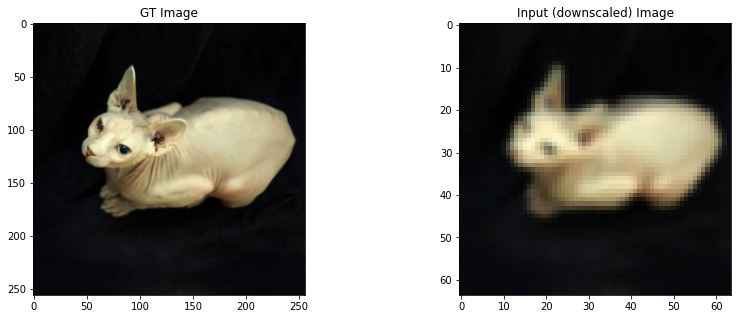

In [ ]:
sample_downscaled_image, sample_image = train_dataset[911]
sample_downscaled_image, sample_image = sample_downscaled_image[0], sample_image[0] # first batch image
display([sample_image, sample_downscaled_image])

## Network definitions
Next, we define our U-Net-like networks. For example, `unet3` has 3 resolution levels in the contracting path, a bottleneck, and 3 resolution levels in the expanding path.

In [ ]:
# Network definitions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, UpSampling2D, Activation, Multiply
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, SeparableConv2D, Dense
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Add, concatenate, Lambda, Reshape
from tensorflow.nn import depth_to_space

# Sub-pixel layer for learnable upsampling
# From: https://github.com/twairball/keras-subpixel-conv/blob/master/subpixel.py
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return depth_to_space(x, scale)


    #return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')
    return Lambda(subpixel, output_shape=subpixel_shape)

def upsample(x, out_channels=16, method='Upsampling2D', upsampling_factor=2,
             input_shape=None):
    if method == 'Conv2DTranspose':
        if input_shape is None:
            x = Conv2DTranspose(out_channels, (2, 2),
                                strides=(upsampling_factor, upsampling_factor),
                                padding='same') (x)
        else:
            x = Conv2DTranspose(out_channels, (2, 2),
                                strides=(upsampling_factor, upsampling_factor),
                                padding='same', input_shape=input_shape) (x)
    elif method == 'Upsampling2D':
        x = UpSampling2D( size=(upsampling_factor, upsampling_factor) )( x )
        x = Conv2D(out_channels, (3, 3), padding='same')(x)
    elif method == 'SubpixelConv2D':
        x = Conv2D(out_channels * upsampling_factor ** 2, (3, 3),
                   padding='same')(x)
        x = SubpixelConv2D( input_shape, scale=upsampling_factor )(x)
    else:
        x = UpSampling2D( size=(upsampling_factor, upsampling_factor) )( x )

    return x
# Regular U-Net
def UNet_part(inputs,
         filters=16,
         activation='elu',
         kernel_initializer = 'he_normal',
         dropout_value=0.2,
         average_pooling=True,
         spatial_dropout=False,
         pixel_shuffle = False):
  """
  regular U-Net structure
       Args:
            filters (int, optional): number of channels at the first level of U-Net
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
                initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
                level and the bottleneck
            average_pooling (bool, optional): use average-pooling between U-Net
                levels (otherwise use max pooling).
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
       Returns:
            model (Keras model): model containing the ResUNet created.
  """
  # make a list of dropout values if needed
  if type( dropout_value ) is float:
            dropout_value = [dropout_value]*5

  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(inputs)
  conv1 = SpatialDropout2D(dropout_value[0], seed=seed)(conv1) if spatial_dropout else Dropout(dropout_value[0], seed=seed) (conv1)
  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv1)
  pool1 = AveragePooling2D(pool_size=(2, 2))(conv1) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool1)
  conv2 = SpatialDropout2D(dropout_value[1], seed=seed)(conv2) if spatial_dropout else Dropout(dropout_value[1], seed=seed) (conv2)
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv2)
  pool2 = AveragePooling2D(pool_size=(2, 2))(conv2) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool2)
  conv3 = SpatialDropout2D(dropout_value[2], seed=seed)(conv3) if spatial_dropout else Dropout(dropout_value[2], seed=seed) (conv3)
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv3)
  pool3 = AveragePooling2D(pool_size=(2, 2))(conv3) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool3)
  conv4 = SpatialDropout2D(dropout_value[3], seed=seed)(conv4) if spatial_dropout else Dropout(dropout_value[3], seed=seed)(conv4)
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv4)
  pool4 = AveragePooling2D(pool_size=(2, 2))(conv4) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool4)
  conv5 = SpatialDropout2D(dropout_value[4], seed=seed)(conv5) if spatial_dropout else Dropout(dropout_value[4], seed=seed)(conv5)
  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv5)
  
  up6 = tf.nn.depth_to_space(conv5, 2) if pixel_shuffle else Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same') (conv5)  
  merge6 = concatenate([conv4,up6], axis = 3)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge6)
  conv6 = SpatialDropout2D(dropout_value[3], seed=seed)(conv6) if spatial_dropout else Dropout(dropout_value[3], seed=seed)(conv6)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv6)

  up7 = tf.nn.depth_to_space(conv6, 2) if pixel_shuffle else Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same') (conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge7)
  conv7 = SpatialDropout2D(dropout_value[2], seed=seed)(conv7) if spatial_dropout else Dropout(dropout_value[2], seed=seed)(conv7)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv7)
  
  up8 = tf.nn.depth_to_space(conv7, 2) if pixel_shuffle else Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same') (conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge8)
  conv8 = SpatialDropout2D(dropout_value[1], seed=seed)(conv8) if spatial_dropout else Dropout(dropout_value[1], seed=seed)(conv8)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv8)
  
  up9 = tf.nn.depth_to_space(conv8, 2) if pixel_shuffle else Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge9)
  conv9 = SpatialDropout2D(dropout_value[0], seed=seed)(conv9) if spatial_dropout else Dropout(dropout_value[0], seed=seed)(conv9)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv9)

  return conv9

def preUNet4(input_size = (None,None,3),
            filters=16,
            activation='elu',
            kernel_initializer = 'he_normal',
            dropout_value=0.2,
            average_pooling=True,
            spatial_dropout=False,
            pixel_shuffle = False,
            upsampling_factor=2,
            upsample_method='UpSampling2D'):

  inputs = Input( input_size )
  
  s = upsample( inputs, out_channels=filters, method=upsample_method,
                     upsampling_factor=upsampling_factor,
                     input_shape=(input_size[0], input_size[1], input_size[2]))

  x = UNet_part(s,
         filters=filters,
         activation=activation,
         kernel_initializer = kernel_initializer,
         dropout_value=dropout_value,
         average_pooling=average_pooling,
         spatial_dropout=spatial_dropout,
         pixel_shuffle = pixel_shuffle)

  x = Add()([s,x]) # long shortcut
  outputs = Conv2D(input_size[2], (1, 1), activation='linear') (x)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  return model

def postUNet4(input_size = (None,None,3),
            filters=16,
            activation='elu',
            kernel_initializer = 'he_normal',
            dropout_value=0.2,
            average_pooling=True,
            spatial_dropout=False,
            pixel_shuffle = False,
            upsampling_factor=2,
            upsample_method='UpSampling2D'):

  inputs = Input( input_size )
  
  conv9 = UNet_part(inputs,
         filters=filters,
         activation=activation,
         kernel_initializer = kernel_initializer,
         dropout_value=dropout_value,
         average_pooling=average_pooling,
         spatial_dropout=spatial_dropout,
         pixel_shuffle = pixel_shuffle)

  conv9 = upsample( conv9, out_channels=1, method=upsample_method,
                    upsampling_factor=upsampling_factor,
                    input_shape=(input_size[0], input_size[1], input_size[2]))

  #outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)
  outputs = Conv2D(1, (1, 1)) (conv9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

# == Residual U-Net ==

def residual_block(x, dim, filter_size, activation='elu', 
                   kernel_initializer='he_normal', dropout_value=0.2, bn=False,
                   first_conv_strides=1, separable_conv=False, firstBlock=False):

    # Create shorcut
    if firstBlock == False:
        shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=first_conv_strides)(x)
    else:
        shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=1)(x)
    
    # Main path
    if firstBlock == False:
        x = BatchNormalization()(x) if bn else x
        x = Activation( activation )(x)
    if separable_conv == False:
        if firstBlock == True:
            x = Conv2D(dim, filter_size, strides=1, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
        else:
            x = Conv2D(dim, filter_size, strides=first_conv_strides, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, strides=first_conv_strides, 
                            activation=None, kernel_initializer=kernel_initializer,
                            padding='same') (x)
    x = SpatialDropout2D( dropout_value, seed=seed ) (x) if dropout_value else x
    x = BatchNormalization()(x) if bn else x
    x = Activation( activation )(x)
      
    if separable_conv == False:
        x = Conv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)

    # Add shortcut value to main path
    x = Add()([shortcut, x])
    print( 'residual block, dim: ' + str(dim) + ' , output shape: '+ str(x.shape) )
    return x

def level_block(x, depth, dim, fs, ac, k, d, bn, fcs, sc, fb, mp, ps):

    if depth > 0:
        r = residual_block(x, dim, fs, ac, k, d, bn, fcs, sc, fb)
        x = MaxPooling2D((2, 2)) (r) if mp else r
        x = level_block(x, depth-1, (dim*2), fs, ac, k, d, bn, fcs, sc, False, mp, ps) 
        x = tf.nn.depth_to_space(x, 2) if ps else  Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([r, x])
        x = residual_block(x, dim, fs, ac, k, d, bn, 1, sc, False)
    else:
        x = residual_block(x, dim, fs, ac, k, d, bn, fcs, sc, False)
    return x


def preResUNet(image_shape, activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, maxpooling=True, separable=False,
            numInitChannels=16, depth=4, upsampling_factor=2,
            upsample_method='UpSampling2D', final_activation=None,
            pixel_shuffle = False):

    """Create the pre-upsampling ResU-Net for super-resolution
       Args:
            image_shape (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value, optional): dropout value
            batchnorm (bool, optional): use batch normalization
            maxpooling (bool, optional): use max-pooling between U-Net levels 
            (otherwise use stride of 2x2).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            numInitChannels (int, optional): number of channels at the
            first level of U-Net
            depth (int, optional): number of U-Net levels
            upsampling_factor (int, optional): initial image upsampling factor
            upsample_method (str, optional): upsampling method to use
            ('UpSampling2D', 'Conv2DTranspose', or 'SubpixelConv2D')
            final_activation (str, optional): activation function for the last
            layer
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input(image_shape) #(None, None, image_shape[2])

    s = upsample( inputs, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))

    conv_strides = (1,1) if maxpooling else (2,2)

    x = level_block(s, depth, numInitChannels, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, conv_strides, separable, True,
                    maxpooling, pixel_shuffle)

    #outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)

    x = Add()([s,x]) # long shortcut

    outputs = Conv2D(image_shape[2], (1, 1), activation=final_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model
def postResUNet(image_shape, activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, maxpooling=True, separable=False,
            numInitChannels=16, depth=4, upsampling_factor=2,
            upsample_method='UpSampling2D', final_activation=None,
            pixel_shuffle = False ):

    """Create the post-upsampling ResU-Net for super-resolution
       Args:
            image_shape (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value, optional): dropout value
            batchnorm (bool, optional): use batch normalization
            maxpooling (bool, optional): use max-pooling between U-Net levels 
            (otherwise use stride of 2x2).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            numInitChannels (int, optional): number of channels at the
            first level of U-Net
            depth (int, optional): number of U-Net levels
            upsampling_factor (int, optional): initial image upsampling factor
            upsample_method (str, optional): upsampling method to use
            ('UpSampling2D', 'Conv2DTranspose', or 'SubpixelConv2D')
            final_activation (str, optional): activation function for the last
            layer
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input(image_shape) #(None, None, image_shape[2])

    conv_strides = (1,1) if maxpooling else (2,2)

    x = level_block(inputs, depth, numInitChannels, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, conv_strides, separable, True,
                    maxpooling, pixel_shuffle)

    x = upsample( x, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))
    

    #outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)
    outputs = Conv2D(image_shape[2], (1, 1), activation=final_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model
def prePostResUNet(image_shape, activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, maxpooling=True, separable=False,
            numInitChannels=16, depth=4, upsampling_factor=2,
            upsample_method='UpSampling2D', final_activation='linear',
            pixel_shuffle = False ):

    """Create the pre- and post-upsampling ResU-Net for super-resolution
       Args:
            image_shape (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value, optional): dropout value
            batchnorm (bool, optional): use batch normalization
            maxpooling (bool, optional): use max-pooling between U-Net levels 
            (otherwise use stride of 2x2).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            numInitChannels (int, optional): number of channels at the
            first level of U-Net
            depth (int, optional): number of U-Net levels
            upsampling_factor (int, optional): initial image upsampling factor
            upsample_method (str, optional): upsampling method to use
            ('UpSampling2D', 'Conv2DTranspose', or 'SubpixelConv2D')
            final_activation (str, optional): activation function for the last
            layer
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input(image_shape) #(None, None, image_shape[2])
    
    s = upsample( inputs, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor/2,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))

    conv_strides = (1,1) if maxpooling else (2,2)

    x = level_block(s, depth, numInitChannels, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, conv_strides, separable, True,
                    maxpooling, pixel_shuffle)

    x = upsample( x, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor/2,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))
    

    #outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)
    outputs = Conv2D(image_shape[2], (1, 1), activation=final_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### RCAN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Add, Lambda, GlobalAveragePooling2D, Multiply, Dense, Reshape
from tensorflow.keras.models import Model

import sys
sys.setrecursionlimit(10000)


def sub_pixel_conv2d(scale=2, **kwargs):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale), **kwargs)


def upsample_rcan(input_tensor, filters):
    x = Conv2D(filters=filters * 4, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = sub_pixel_conv2d(scale=2)(x)
    x = Activation('relu')(x)
    return x


def ca(input_tensor, filters, reduce=16):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Reshape((1, 1, filters))(x)
    x = Dense(filters/reduce,  activation='relu', kernel_initializer='he_normal', use_bias=False)(x)
    x = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)
    x = Multiply()([x, input_tensor])
    return x


def rcab(input_tensor, filters, scale=0.1):
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = ca(x, filters)
    if scale:
        x = Lambda(lambda t: t * scale)(x)
    x = Add()([x, input_tensor])

    return x


def rg(input_tensor, filters, n_rcab=20):
    x = input_tensor
    for _ in range(n_rcab):
        x = rcab(x, filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x, input_tensor])

    return x


def rir(input_tensor, filters, n_rg=10):
    x = input_tensor
    for _ in range(n_rg):
        x = rg(x, filters=filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x, input_tensor])

    return x


def rcan(filters=64, n_sub_block=2, input_size=(None,None,3)):
    inputs = Input(shape=input_size)

    x = x_1 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(inputs)
    x = rir(x, filters=filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x_1, x])

    for _ in range(n_sub_block):
        x = upsample_rcan(x, filters)
        
    outputs = Conv2D(filters=input_size[2], kernel_size=3, strides=1, padding='same')(x)

    return Model(inputs=inputs, outputs=outputs)

### Res-CAUNet

In [ ]:
# == Residual U-Net ==

def ca(input_tensor, filters, reduce=16):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Reshape((1, 1, filters))(x)
    x = Dense(filters/reduce,  activation='relu', kernel_initializer='he_normal', use_bias=False)(x)
    x = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)
    x = Multiply()([x, input_tensor])
    return x

def resCA_block(x, dim, filter_size, activation='elu', 
                   kernel_initializer='he_normal', dropout_value=0.2, bn=False,
                   first_conv_strides=1, separable_conv=False, firstBlock=False):

    # Create shorcut
    if firstBlock == False:
        shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=first_conv_strides)(x)
    else:
        shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=1)(x)
    
    # Main path
    if firstBlock == False:
        x = BatchNormalization()(x) if bn else x
        x = Activation( activation )(x)
    if separable_conv == False:
        if firstBlock == True:
            x = Conv2D(dim, filter_size, strides=1, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
        else:
            x = Conv2D(dim, filter_size, strides=first_conv_strides, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, strides=first_conv_strides, 
                            activation=None, kernel_initializer=kernel_initializer,
                            padding='same') (x)
    x = SpatialDropout2D( dropout_value, seed=seed ) (x) if dropout_value else x
    x = BatchNormalization()(x) if bn else x
    x = Activation( activation )(x)
      
    if separable_conv == False:
        x = Conv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)

    # channel attention
    x = ca(x, dim)

    # Add shortcut value to main path
    x = Add()([shortcut, x])
    print( 'residual block, dim: ' + str(dim) + ' , output shape: '+ str(x.shape) )
    return x

def level_block_CA(x, depth, dim, fs, ac, k, d, bn, fcs, sc, fb, mp, ps):

    if depth > 0:
        r = resCA_block(x, dim, fs, ac, k, d, bn, fcs, sc, fb)
        x = MaxPooling2D((2, 2)) (r) if mp else r
        x = level_block_CA(x, depth-1, (dim*2), fs, ac, k, d, bn, fcs, sc, False, mp, ps) 
        x = tf.nn.depth_to_space(x, 2) if ps else  Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([r, x])
        x = resCA_block(x, dim, fs, ac, k, d, bn, 1, sc, False)
    else:
        x = resCA_block(x, dim, fs, ac, k, d, bn, fcs, sc, False)
    return x


def preResCAUNet(image_shape, activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, maxpooling=True, separable=False,
            numInitChannels=16, depth=4, upsampling_factor=2,
            upsample_method='UpSampling2D', final_activation=None,
            pixel_shuffle = False):

    """Create the pre-upsampling ResU-Net for super-resolution
       Args:
            image_shape (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value, optional): dropout value
            batchnorm (bool, optional): use batch normalization
            maxpooling (bool, optional): use max-pooling between U-Net levels 
            (otherwise use stride of 2x2).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            numInitChannels (int, optional): number of channels at the
            first level of U-Net
            depth (int, optional): number of U-Net levels
            upsampling_factor (int, optional): initial image upsampling factor
            upsample_method (str, optional): upsampling method to use
            ('UpSampling2D', 'Conv2DTranspose', or 'SubpixelConv2D')
            final_activation (str, optional): activation function for the last
            layer
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input(image_shape) #(None, None, image_shape[2])

    s = upsample( inputs, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))

    conv_strides = (1,1) if maxpooling else (2,2)

    x = level_block_CA(s, depth, numInitChannels, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, conv_strides, separable, True,
                    maxpooling, pixel_shuffle)

    #outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)

    x = Add()([s,x]) # long shortcut

    outputs = Conv2D(image_shape[2], (1, 1), activation=final_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

## Train the model

In [ ]:
# === Training parameters ===
# number of epochs
numEpochs = 50
# patience
patience = 5
# learning rate
lr = 1e-3
# use one-cycle policy for super-convergence? Reduce on plateau?
schedule = 'reduce' #'oneCycle' # 'reduce' # None
# Network architecture: preResUNet, postResUNet, prePostResUNet, preUNet4, postUNet4, RCAN
model_name = 'RCAN'
# Optimizer name: 'Adam', 'SGD', 'rmsprop'
optimizer_name = 'rmsprop'
# Loss function name: 'mix', 'ms_ssim', 'MAE', 'MSE'
loss_acronym = 'MSE'
# initial channels
num_init_ch = 32
# upsample method: # 'Upsampling2D' , 'SubpixelConv2D', 'Conv2DTranspose'
upsample_method='SubpixelConv2D'
# activartion function
activation = 'elu'
# last activation function
final_activation = 'linear'
# instead of TConv use pixel shuffle
pixel_shuffle = False

# Show images of one generated image each epoch
show_progress = False

### Get selected model and compile

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.backend import clear_session

# Free up RAM in case the model definition cells were run multiple times
clear_session()

# create the network and compile it with its optimizer
if model_name == 'preResUNet':
    model = preResUNet( numInitChannels=num_init_ch,
        image_shape = downscale_img_size + (3,), 
        upsampling_factor = up_factor,
        dropout_value=0.2, # spatial_dropout(dropout_value) if dropout_value
        upsample_method = upsample_method,
        final_activation = final_activation,
        activation=activation,
        pixel_shuffle = pixel_shuffle)
if model_name == 'preResCAUNet':
    model = preResCAUNet( numInitChannels=num_init_ch,
        image_shape = downscale_img_size + (3,), 
        upsampling_factor = up_factor,
        dropout_value=0.2, # spatial_dropout(dropout_value) if dropout_value
        upsample_method = upsample_method,
        final_activation = final_activation,
        activation=activation,
        pixel_shuffle = pixel_shuffle)
elif model_name == 'postResUNet':
    model = postResUNet( numInitChannels=num_init_ch,
        image_shape = downscale_img_size + (3,), 
        upsampling_factor = up_factor,
        upsample_method = upsample_method,
        final_activation = final_activation,
        activation=activation,
        pixel_shuffle = pixel_shuffle)
elif model_name == 'prePostResUNet':
    model = prePostResUNet(image_shape = downscale_img_size + (3,),
        kernel_initializer='he_normal', dropout_value=0.2,
         batchnorm=False, maxpooling=True, separable=False,
        numInitChannels=num_init_ch, depth=4, upsampling_factor=up_factor,
        upsample_method = upsample_method, final_activation = final_activation,
        activation=activation, pixel_shuffle = pixel_shuffle) 
elif model_name == 'preUNet4':
    model = preUNet4(filters=num_init_ch, 
        input_size = downscale_img_size + (3,),
        upsampling_factor=up_factor, spatial_dropout=False,
        upsample_method = upsample_method,
        activation=activation, pixel_shuffle = pixel_shuffle)
elif model_name == 'postUNet4':
    model = postUNet4(filters=num_init_ch, 
        input_size = downscale_img_size + (3,),
        upsampling_factor=up_factor, spatial_dropout=False, 
        upsample_method = upsample_method,
        activation=activation, pixel_shuffle = pixel_shuffle)
elif model_name == 'RCAN':
    model = rcan(n_sub_block=int(np.log2(down_factor)),
                 filters=num_init_ch,
                 input_size=downscale_img_size + (3,))
model.summary()

if optimizer_name == 'SGD':
    optim =  tf.keras.optimizers.SGD(
            lr=lr, momentum=0.99, decay=0.0, nesterov=False)
elif optimizer_name == 'Adam':
    optim = tf.keras.optimizers.Adam( learning_rate=lr )
elif optimizer_name == 'rmsprop':
    optim = tf.keras.optimizers.RMSprop( learning_rate=lr )


if loss_acronym == 'mix':
    loss_funct = [mix_loss(max_val=1, alpha=0.84)]
elif loss_acronym == 'MAE':
    loss_funct = 'mean_absolute_error'
elif loss_acronym == 'MSE':
    loss_funct = 'mean_squared_error'
elif loss_acronym == 'ms_ssim':
    loss_funct = [ms_ssim_loss(max_val=1)]


eval_metric = 'mean_squared_error'

# compile the model with the specific optimizer, loss function and metric
model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric, psnr, ssim])

# callback for early stop
earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

if schedule == 'oneCycle':
    # callback for one-cycle schedule
    steps = np.ceil(len(train_dataset) / BATCH_SIZE) * numEpochs
    lr_schedule = OneCycleScheduler(lr, steps)
elif schedule == 'reduce':
    # callback to reduce the learning rate in the plateau
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=patience, min_lr=(lr/10))
else:
    lr_schedule = None

callbacks = [earlystopper] if lr_schedule is None else [earlystopper, lr_schedule]

if show_progress:
    callbacks.append(DisplayCallback())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### ¡¡¡ Train !!!

In [ ]:
#print('Initial learning rate: {:0.5f}'.format(model.optimizer.lr.numpy()))

# Train the model, doing validation at the end of each epoch.
history = model.fit(  train_dataset, validation_data=val_dataset, 
            epochs=numEpochs, callbacks=callbacks)
#print('Final learning rate: {:0.5f}'.format(model.optimizer.lr.numpy()))

Plot loss - IoU

In [ ]:
plot_loss_and_metric(eval_metric, history)

### save model

In [ ]:
if not os.path.exists('/models/'):
    os.makedirs('/models/')

# Save weights for future reuse
if schedule is None:
    schedule = 'None'
weights_filename = '/models/SR-weights-' + model_name+'-nf-'+str(num_init_ch)+'-'+loss_acronym+'-bs-'+str(BATCH_SIZE)+'-'+optimizer_name+'-'+schedule+'.h5'
model.save_weights( weights_filename )
print( 'Saved model as ' + weights_filename )

#### show model architecture
Have a quick look at the resulting model architecture:

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Testing

### Load saved model 
If you want. By **default** is **disabled**

In [ ]:
use_saved_model = False

if use_saved_model:
    if model_name == 'preResUNet':
        model = preResUNet( numInitChannels=16, image_shape = img_size + (3,),
            upsampling_factor = down_factor, upsample_method='SubpixelConv2D',
            final_activation = 'linear')
    elif model_name == 'postResUNet':
        model = postResUNet( numInitChannels=16, image_shape = img_size + (3,),
            upsampling_factor = down_factor, upsample_method='SubpixelConv2D',
            final_activation = 'linear')

    # Restore the weights
    model.load_weights('/models/weights-example-unet-nf-32-SCCE-bs-32-rmsprop-None.h5') # change this

    # compile the model with the specific optimizer, loss function and metric
    model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric])

### Visualize predictions

In [ ]:
from skimage import metrics

psnr_mean = []
ssim_mean = []
for ds_img, gt_img in tqdm(test_dataset):
    predictions = model.predict(ds_img)
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        pred = np.clip( pred, a_min=0, a_max=1 )

        gt = gt_img[i]
        
        psnr_mean.append(metrics.peak_signal_noise_ratio(pred, gt))
        ssim_mean.append(metrics.structural_similarity(pred, gt, multichannel=True))

psnr_mean = np.mean(psnr_mean)
ssim_mean = np.mean(ssim_mean)

print("\n Test mean PSNR:", psnr_mean)
print("Test mean SSIM:", ssim_mean)

In [ ]:
show_predictions(test_dataset, 3, 1077)